# Using the low-level API from HSSM directly with PyMC

In addition to the high-level API that relies on `bambi` for model creation, HSSM also features a low-level API that it internally calls for creating `pytensor` `Op`s and `pm.Distribution`s. Experienced users can use the low-level API directly with `PyMC` to create even more customized models. This tutorial shows how advanced users can utilize the low-level API that HSSM offers to interface with PyMC.

In [8]:
import arviz as az
import hssm
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import ssms.basic_simulators

from hssm.distribution_utils import (
    make_distribution,  # A general function for making Distribution classes
    make_distribution_from_onnx,  # Makes Distribution classes from onnx files
    make_distribution_from_blackbox,  # Makes Distribution classes from callables
    make_ssm_rv,  # Makes a RandomVariable class
)

# API for creating pytensor Ops from JAX functions
from hssm.distribution_utils.onnx import (
    make_jax_logp_funcs_from_onnx,
    make_jax_logp_ops,
    make_pytensor_logp,
)

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import DDM, DDM_SDV

pytensor.config.floatX = "float32"

## Build a model directly from PyMC

With `DDM` and `DDM_SDV` which are `pm.Distribution`s, we can create models directly with PyMC. We first simulate some data using `ssm_simulators` and then use `PyMC` to specify the model and sample from the it.

In [9]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_ddm = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)
obs_ddm = np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]])
dataset = pd.DataFrame(obs_ddm, columns=["rt", "response"])

dataset

,rt,response
0,4.756874,1.0
1,3.092994,1.0
2,1.515991,1.0
3,4.831869,-1.0
4,3.023999,1.0
...,...,...
995,1.467991,-1.0
996,0.919998,1.0
997,4.210914,1.0
998,4.994857,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>]],
      dtype=object)

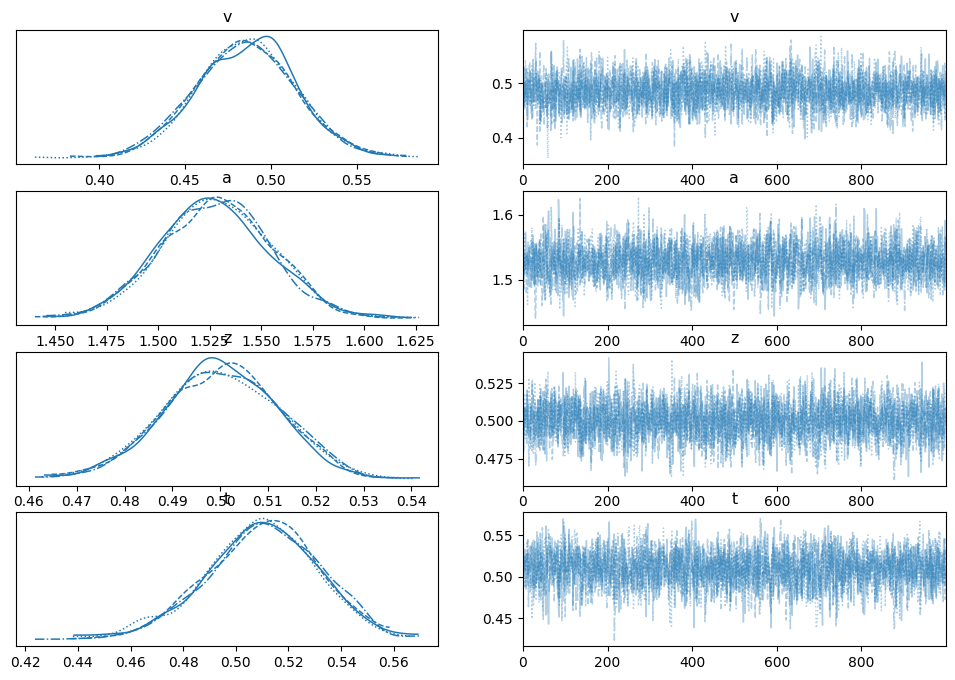

In [12]:
with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("ddm", v=v, a=a, z=z, t=t, observed=dataset.values)

    ddm_pymc_trace = pm.sample()

az.plot_trace(ddm_pymc_trace);